<div style="display:inline;"><div style="text-align:left;">University Mohammed VI<br>
Polytechnic (UM6P)<br>
College of computing<br>
</div>
<div style="text-align:right;">
Année: 2023-2024<br>
</div>
</div>

**Student Name**: DOSSEH AMECK GUY-MAX DESIRE 

# <center> Lab 7: Ensembles learning</center>

## Using trees to detect trees

We will be using tree-based ensemble methods on the [Covertype dataset](https://www.openml.org/d/180).
It contains about 100,000 observations of 7 types of trees (Spruce, Pine, Cottonwood, Aspen,...) described by 55 features describing elevation, distance to water, soil type, etc.

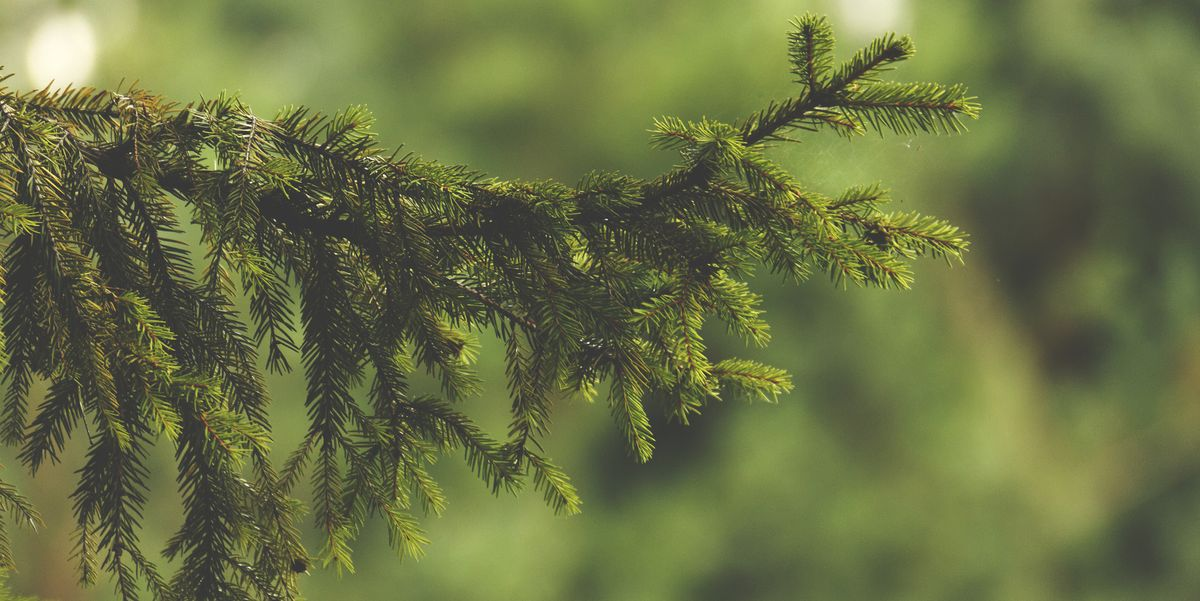

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import random
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns
from matplotlib import cm

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold    
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, auc, roc_curve, roc_auc_score 

from print_versions import print_versions
print_versions(globals())

import sys
print(sys.version)
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from tqdm.notebook import tqdm 

from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
import xgboost
from xgboost import XGBClassifier

sklearn==1.3.2
numpy==1.24.4
pandas==2.0.3
openml==0.14.2
seaborn==0.13.2
3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]


In [2]:
seed = 1
random.seed(seed)
np.random.seed(seed)



In [3]:
# Download Covertype data. Takes a while the first time.
covertype = oml.datasets.get_dataset(180)
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array');
classes = covertype.retrieve_class_labels()
features = [f.name for i,f in covertype.features.items()][:-1]

In [4]:
pd.DataFrame(X, columns=features).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110393 entries, 0 to 110392
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   elevation                           110393 non-null  float32
 1   aspect                              110393 non-null  float32
 2   slope                               110393 non-null  float32
 3   horizontal_distance_to_hydrology    110393 non-null  float32
 4   Vertical_Distance_To_Hydrology      110393 non-null  float32
 5   Horizontal_Distance_To_Roadways     110393 non-null  float32
 6   Hillshade_9am                       110393 non-null  float32
 7   Hillshade_Noon                      110393 non-null  float32
 8   Hillshade_3pm                       110393 non-null  float32
 9   Horizontal_Distance_To_Fire_Points  110393 non-null  float32
 10  wilderness_area1                    110393 non-null  float32
 11  wilderness_area2          

In [5]:
classes

['Aspen',
 'Cottonwood_Willow',
 'Douglas_fir',
 'Krummholz',
 'Lodgepole_Pine',
 'Ponderosa_Pine',
 'Spruce_Fir']

In [6]:
# correlation heatmap of numerical features
pd.DataFrame(X, columns=features).select_dtypes(include='number').corr().style.background_gradient(cmap='coolwarm')

In [7]:
features[0:20]

['elevation',
 'aspect',
 'slope',
 'horizontal_distance_to_hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'wilderness_area1',
 'wilderness_area2',
 'wilderness_area3',
 'wilderness_area4',
 'soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6']

To understand the data a bit better, we can use a scatter matrix. From this, it looks like elevation is a relevant feature.
Douglas Fir and Aspen grow at low elevations, while only Krummholz pines survive at very high elevations.

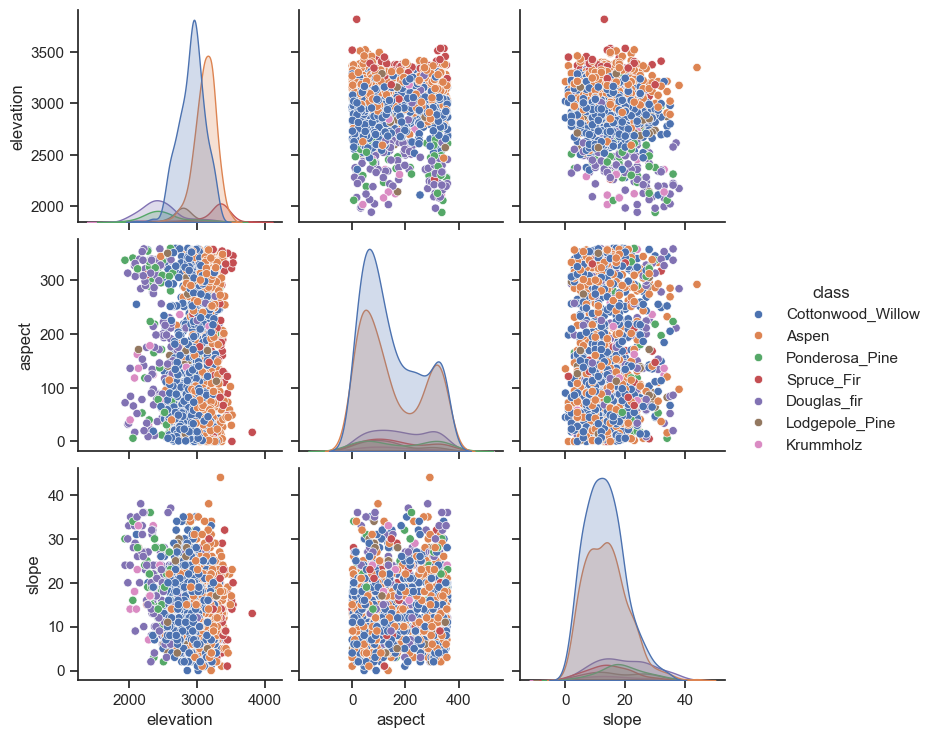

In [8]:
# Using seaborn to build the scatter matrix
# only first 3 columns, first 1000 examples
n_points = 1500
df = pd.DataFrame(X[:n_points,:3], columns=features[:3])
df['class'] = [classes[i] for i in y[:n_points]]
sns.set(style="ticks")
sns.pairplot(df, hue="class");

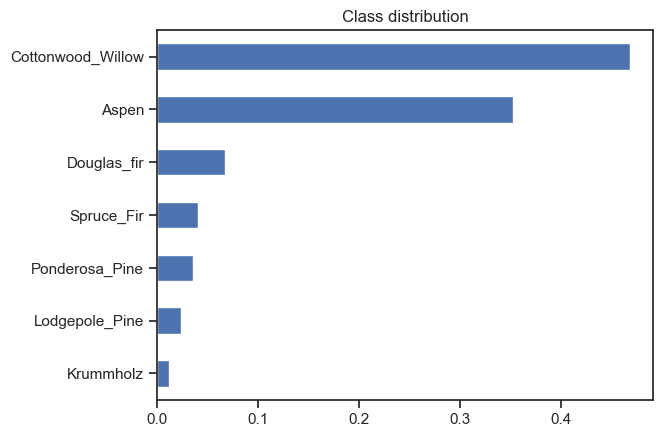

In [9]:
pd.Series(y).replace({i:classes[i] for i in range(len(classes))}).value_counts(normalize=True, ascending=True).plot(kind='barh', title='Class distribution');

In [10]:
data = pd.DataFrame(X, columns=features)

In [11]:
data["Cover_Type"] = y

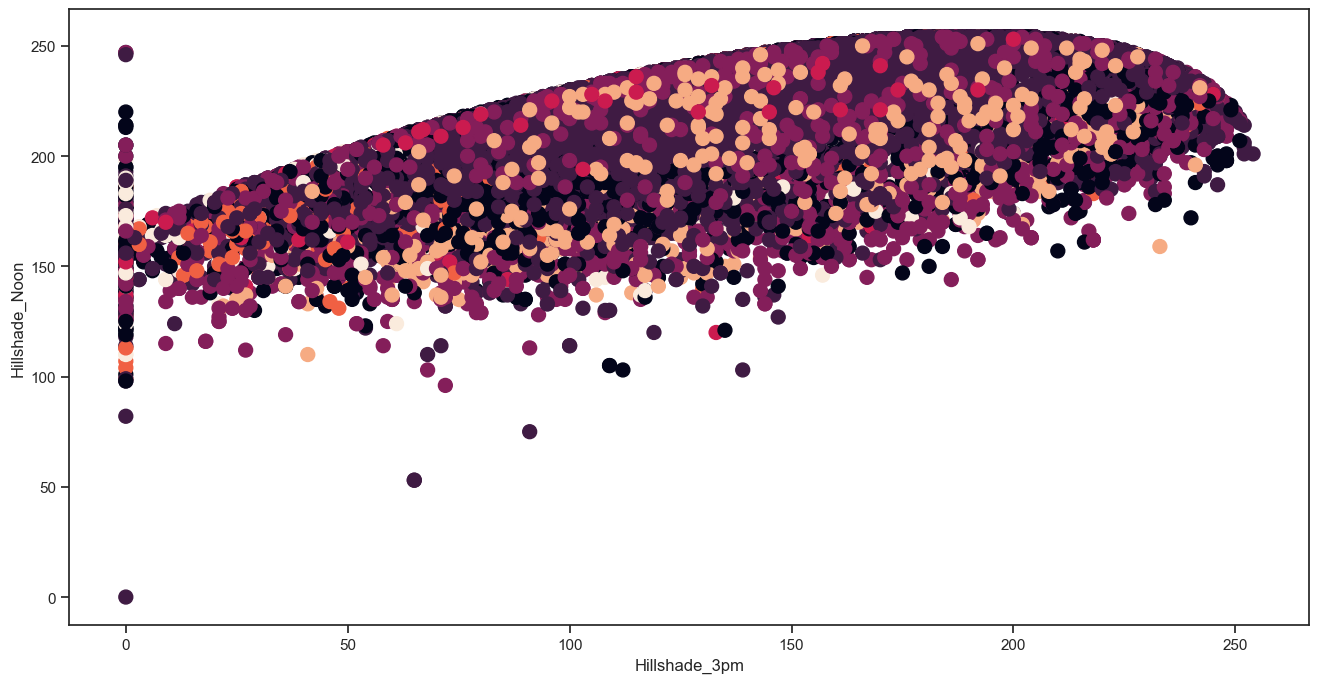

In [12]:
def plotc(data, c1,c2):

    fig = plt.figure(figsize=(16,8))
    sel = np.array(list(data.Cover_Type.values))

    plt.scatter(c1, c2, c=sel, s=100)
    plt.xlabel(c1.name)
    plt.ylabel(c2.name)
    
plotc(data, data.Hillshade_3pm, data.Hillshade_Noon)

- We notice that some values of `hill shade 3pm` are zeros. We can assume that these are missing data and could try to replace them by either the mean or median of the values.

In [13]:
# replace zeros in Hillshade_3pm by rf prediction
rf = RandomForestRegressor(random_state=seed)
rf.fit(data.loc[data.Hillshade_3pm!=0][["Hillshade_Noon", "Hillshade_9am"]], data.loc[data.Hillshade_3pm!=0].Hillshade_3pm)

RandomForestRegressor(random_state=1)

In [14]:
data.Hillshade_3pm = data.apply(lambda x: rf.predict(pd.DataFrame(x[["Hillshade_Noon", "Hillshade_9am"]]).T)  if x.Hillshade_3pm==0 else x.Hillshade_3pm, axis=1)

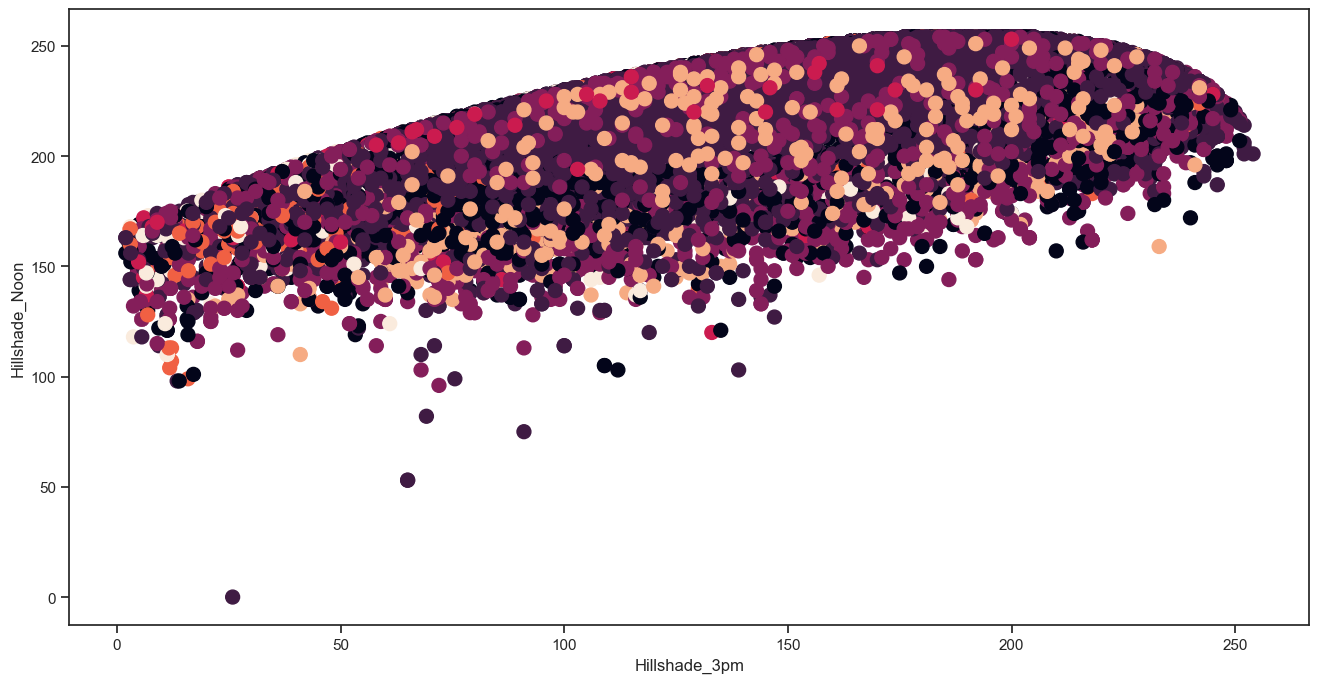

In [15]:
plotc(data, data.Hillshade_3pm, data.Hillshade_Noon)

In [16]:
def r(x):
    # shift aspect in degrees azimuth at 180
    if x+180>360:
        return x-180
    else:
        return x+180
    
def feature_engineering(df):
    # https://www.kaggle.com/code/codename007/forest-cover-type-eda-baseline-model
    # https://nbviewer.org/github/aguschin/kaggle/blob/master/forestCoverType_featuresEngineering.ipynb
    df["aspect2"] = df.aspect.map(r)
    df['highwater'] = df.Vertical_Distance_To_Hydrology < 0
    df['EVDtH'] = df.elevation-df.Vertical_Distance_To_Hydrology
    # df['EHDtH'] = df.elevation-df.horizontal_distance_to_hydrology*0.2
    # df['distance_to_hydrolody'] = (df['horizontal_distance_to_hydrology']**2+df['Vertical_Distance_To_Hydrology']**2)**0.5

    # df['Hydro_Fire_1'] = df['horizontal_distance_to_hydrology']+df['Horizontal_Distance_To_Fire_Points']
  
    # df['Hydro_Fire_2'] = abs(df['horizontal_distance_to_hydrology']-df['Horizontal_Distance_To_Fire_Points'])
 
    # df['Hydro_Road_1'] = abs(df['horizontal_distance_to_hydrology']+df['Horizontal_Distance_To_Roadways'])
 
    # df['Hydro_Road_2'] = abs(df['horizontal_distance_to_hydrology']-df['Horizontal_Distance_To_Roadways'])
    
    # df['Fire_Road_1'] = abs(df['horizontal_distance_to_hydrology']+df['Horizontal_Distance_To_Roadways'])
    
    # df['Fire_Road_2'] = abs(df['horizontal_distance_to_hydrology']-df['Horizontal_Distance_To_Roadways'])
    
    # df.distance_to_hydrolody=df.distance_to_hydrolody.map(lambda x: 0 if np.isinf(x) else x) # remove infinite value if any

    #Mean distance to Amenities 
    df['mean_amenities']=(df.Horizontal_Distance_To_Fire_Points + df.horizontal_distance_to_hydrology + df.Horizontal_Distance_To_Roadways) / 3 
    #Mean Distance to Fire and Water 
    # df['mean_fire_hyd']=(df.Horizontal_Distance_To_Fire_Points + df.horizontal_distance_to_hydrology) / 2 

    return df
  

In [17]:
data = feature_engineering(data)
X= data.drop("Cover_Type", axis=1).values 

In [18]:
features = data.drop("Cover_Type", axis=1).columns.tolist()

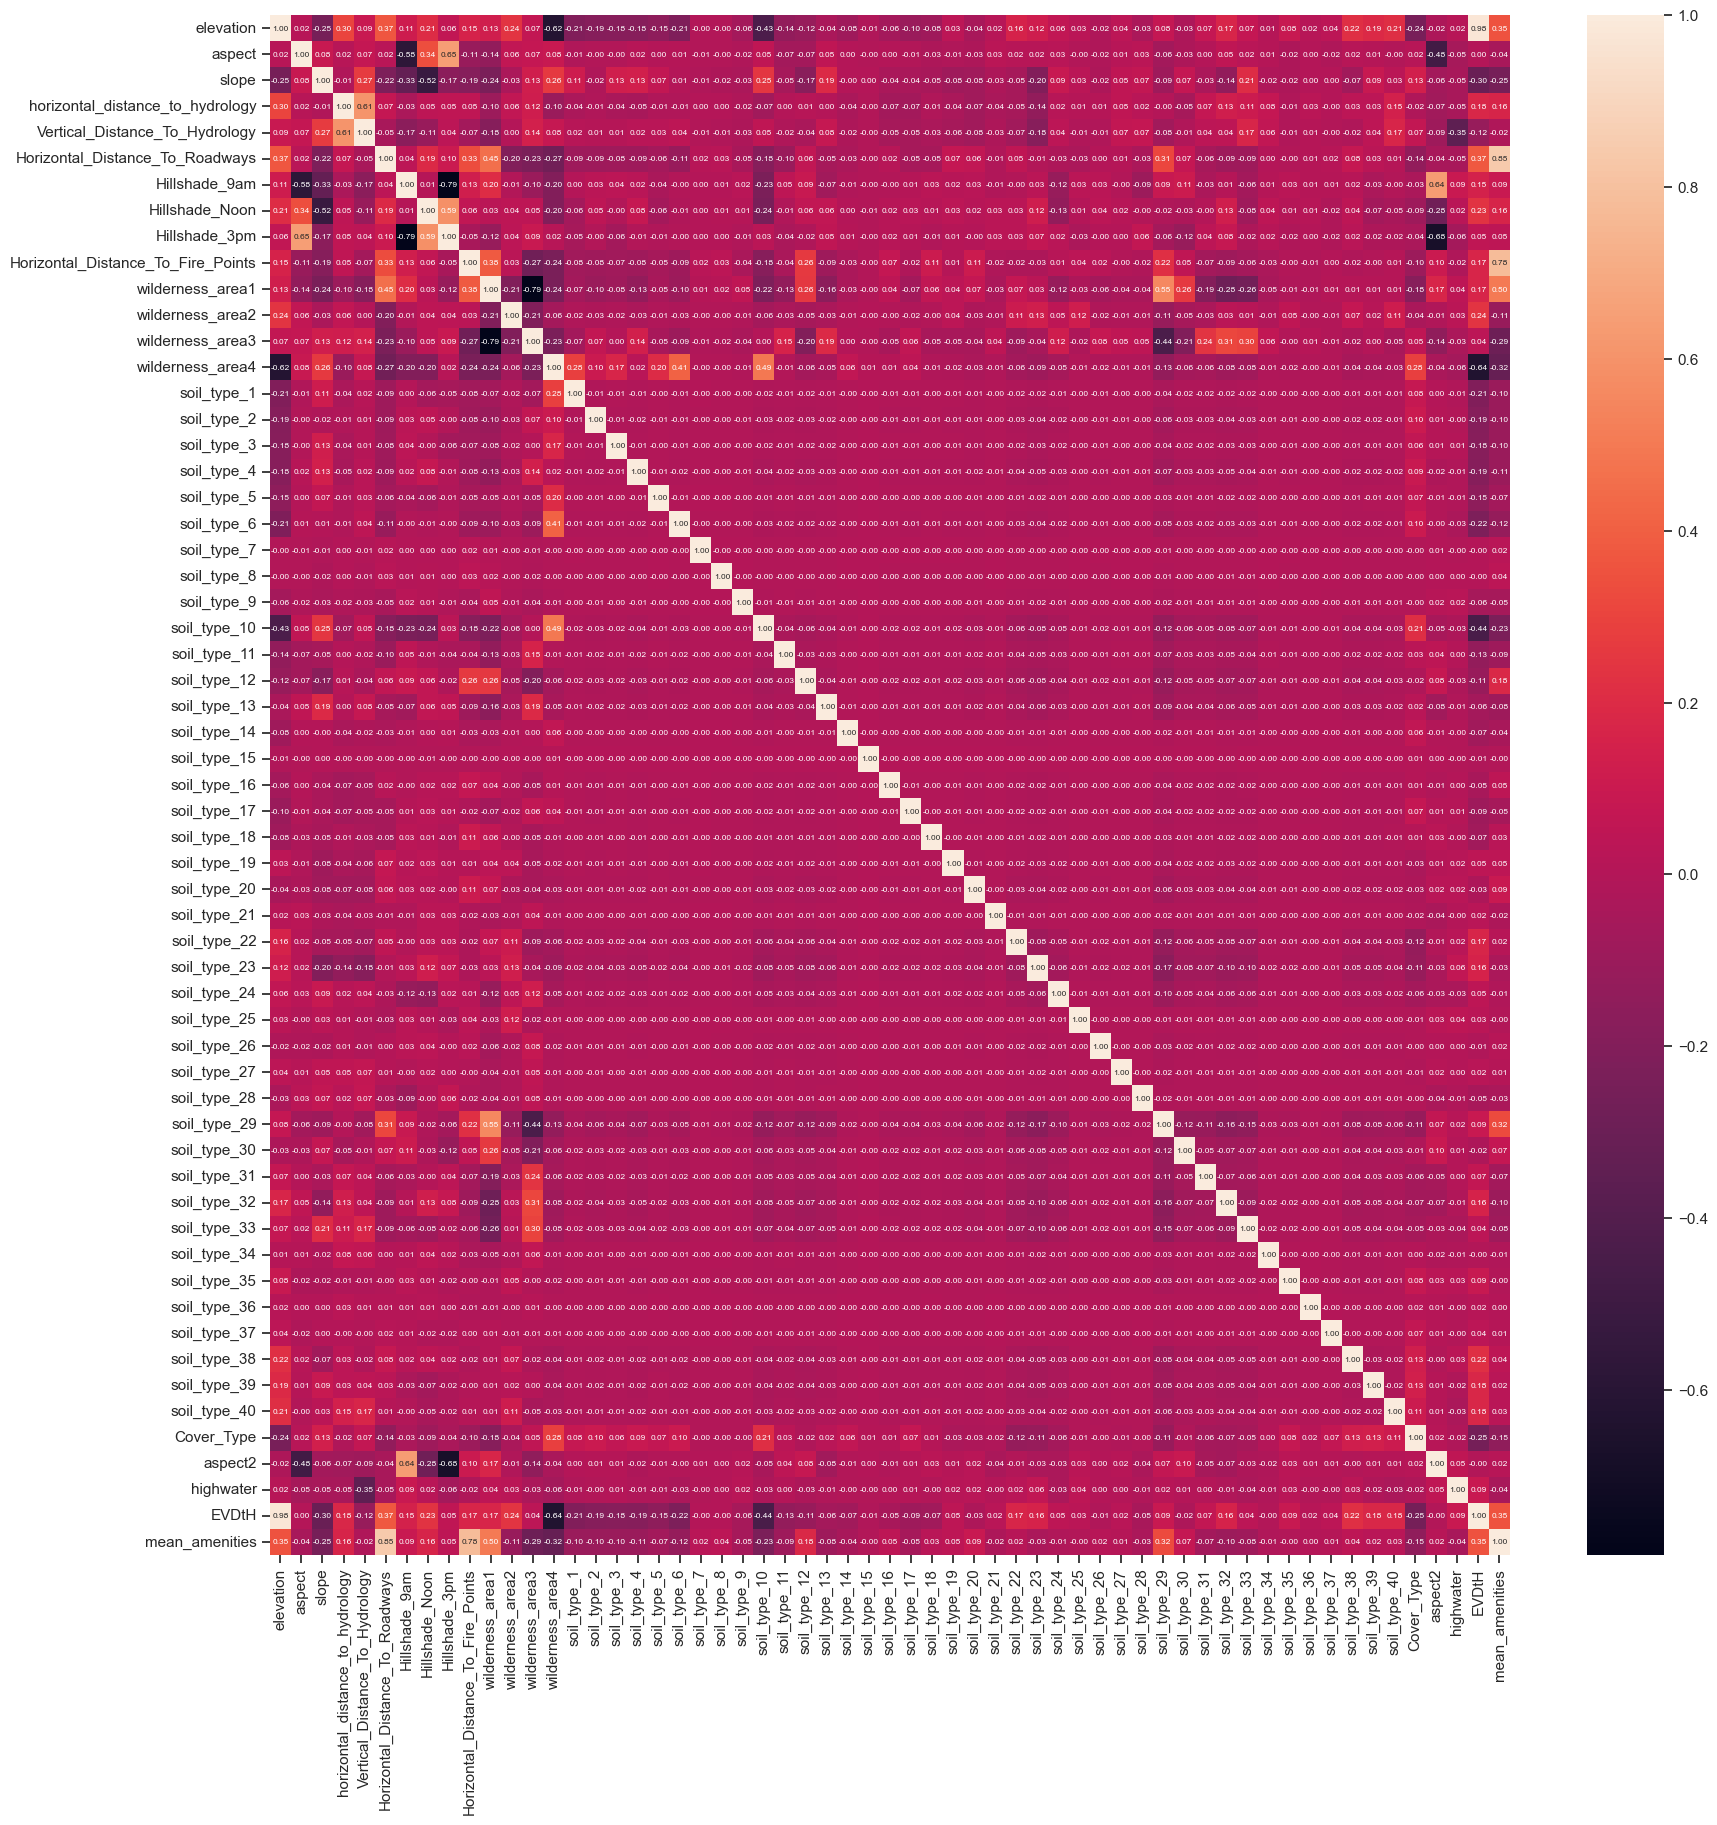

In [19]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, fmt=".2f", annot_kws={"fontsize":6})
plt.show()

## Exercise 1: Random Forests
Implement a function `evaluate_RF` that measures the performance of a Random Forest Classifier, using trees
of (max) depth 2,8,32,64, for any number of trees in the ensemble (`n_estimators`).
For the evaluation you should measure accuracy using 3-fold cross-validation.
Use `random_state=1` to ensure reproducibility. Finally, plot the results for at least 5 values of `n_estimators` ranging from 1 to 30. You can, of course, reuse code from earlier labs and assignments. Interpret the results.
You can take a 50% subsample to speed the plotting.

In [20]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

def evaluate_RF(X, y, grid_params, skf, accuracy=True):
    
    grid_search = GridSearchCV(RandomForestClassifier(random_state=seed, n_jobs=-1, verbose=1), grid_params, cv=skf, n_jobs=-1, verbose=1,
                               scoring=('accuracy', 'f1_macro', 'balanced_accuracy'), refit='balanced_accuracy')
    grid_search.fit(X, y)
    results = pd.DataFrame(grid_search.cv_results_)
    plt.figure(figsize=(15, 8))
    if accuracy:
        sns.heatmap(results.pivot_table(index='param_n_estimators', columns='param_max_depth', values='mean_test_accuracy'), annot=True, fmt=".3f")
        plt.title('Mean test accuracy')
    else:
        sns.heatmap(results.pivot_table(index='param_n_estimators', columns='param_max_depth', values='mean_test_balanced_accuracy'), annot=True, fmt=".3f")
        plt.title('Mean test balanced accuracy')
    plt.show()
    return results, grid_search.best_estimator_

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    6.0s finished


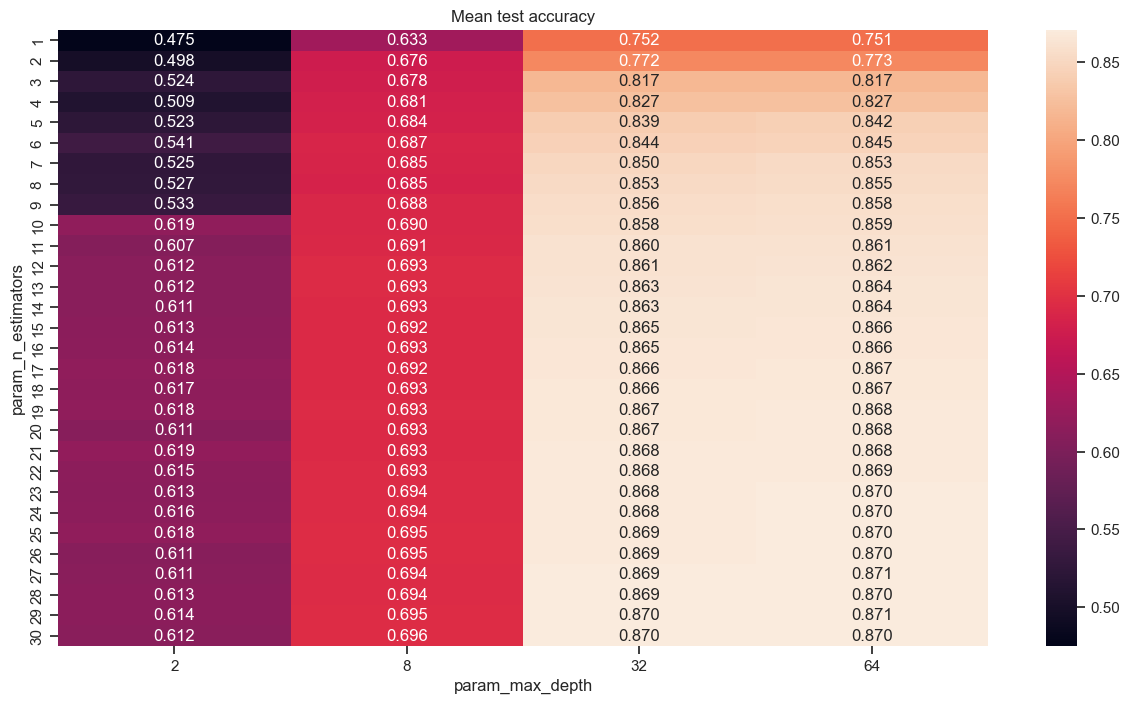

In [21]:
grid_params = {
        'n_estimators': np.arange(1, 31, 1),
        'max_depth': [2, 8, 32, 64]
    }
results_df, best_rf = evaluate_RF(X, y, grid_params, skf) 

**Interpret the results.**

- For `max_depth` less or equal than **8**, the model underfits and the accuracy doesn't cross the **70%**. We also observe a low accuracy when the number of estimators is less than 3.
- The model with the best accuracy is obatained with `max_depth` of 32 and `n_estimators` of 29. 

## Exercise 2: Other measures
Repeat the same plot but now use balanced_accuracy as the evaluation measure. See the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).
Only use the optimal max_depth from the previous question. Do you see an important difference?

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    5.4s finished


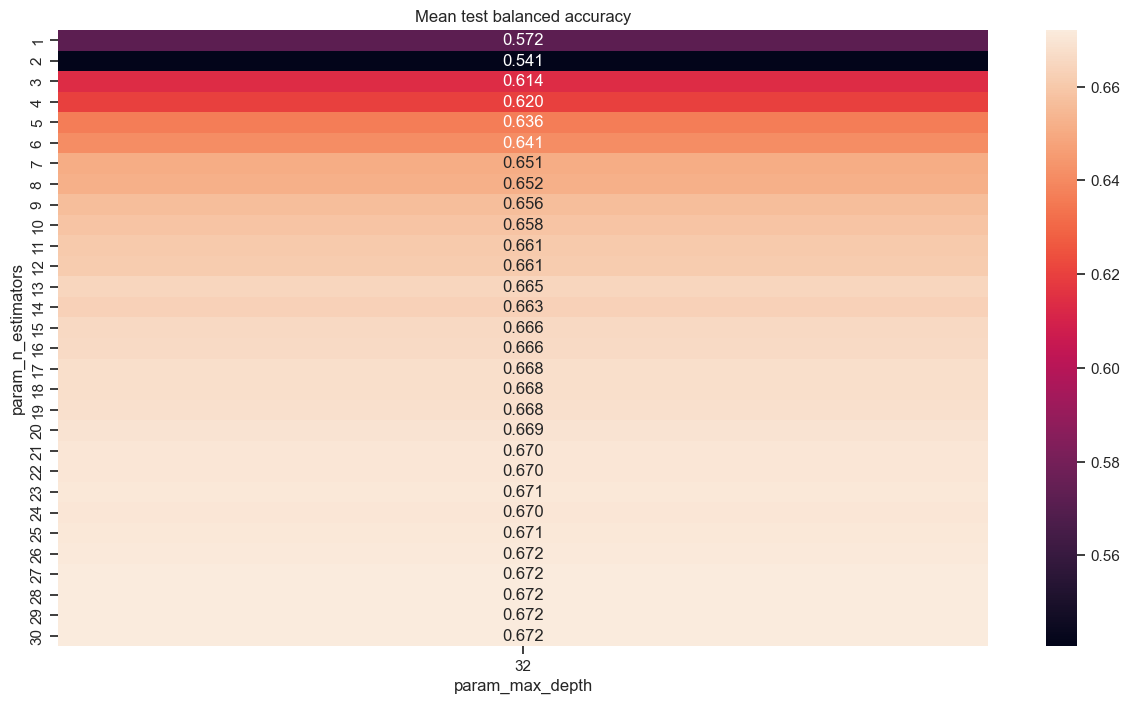

In [22]:
grid_params = {
        'n_estimators': np.arange(1, 31, 1),
        'max_depth': [32]
    }
results_df, best_rf = evaluate_RF(X, y, grid_params, skf, accuracy=False) 

**Do you see an important difference?**

- The model with the highest `balanced_accuracy` is the one with `n_estimators` equals to 26. Using a metric taking in account the unbalance aspect of the classes leads us to go less deeper in the decision tree.

## Exercise 3: Feature importance
Retrieve the feature importances according to the (tuned) random forest model. Which feature are most important?

In [23]:
# map each feature to a name without "_"
feature_names = {f: f.replace('_', ' ') for f in features}

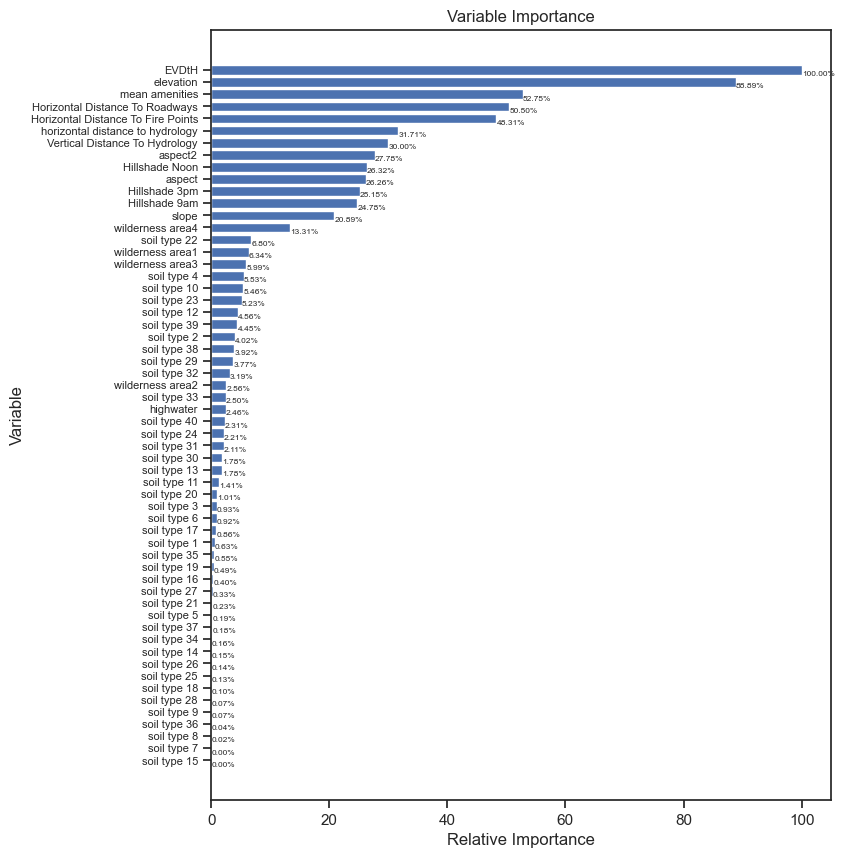

In [24]:
# feature importances
feature_importances = best_rf.feature_importances_

# Make importances relative to max importance.
feature_importances = 100.0 * (feature_importances / feature_importances.max())
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(8, 10))

plt.barh(pos, feature_importances[sorted_idx], align='center')

# add percentage labels with font size 6
for i, idx in enumerate(sorted_idx):
    plt.text(feature_importances[idx], i, f'{feature_importances[idx]:.2f}%', fontsize=6)

plt.yticks(pos, np.array([feature_names[i] for i in np.array(features)[sorted_idx]]), fontsize=8)

plt.xlabel('Relative Importance')
plt.ylabel('Variable')
plt.title('Variable Importance')
plt.show()


**Which feature are most important?**

- EVDtH
- Elevation
- Mean Amenities
- Horizontal Distance to Roadways
- Horizontal Distance to Fire Points
- Horizontal and Vertical Distance to Hydrology

## Exercise 4: Feature selection
Re-build your tuned random forest, but this time only using the first 10 features.
Return both the balanced accuracy and training time. Interpret the results.

In [25]:
pd.DataFrame({'feature': features, 'importance': feature_importances}).sort_values('importance', ascending=False).head(10)

feature  importance
56                               EVDtH  100.000000
0                            elevation   88.885070
57                      mean_amenities   52.750232
5      Horizontal_Distance_To_Roadways   50.497649
9   Horizontal_Distance_To_Fire_Points   48.309223
3     horizontal_distance_to_hydrology   31.713616
4       Vertical_Distance_To_Hydrology   29.998662
54                             aspect2   27.783211
7                       Hillshade_Noon   26.323673
1                               aspect   26.262326

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.3s finished


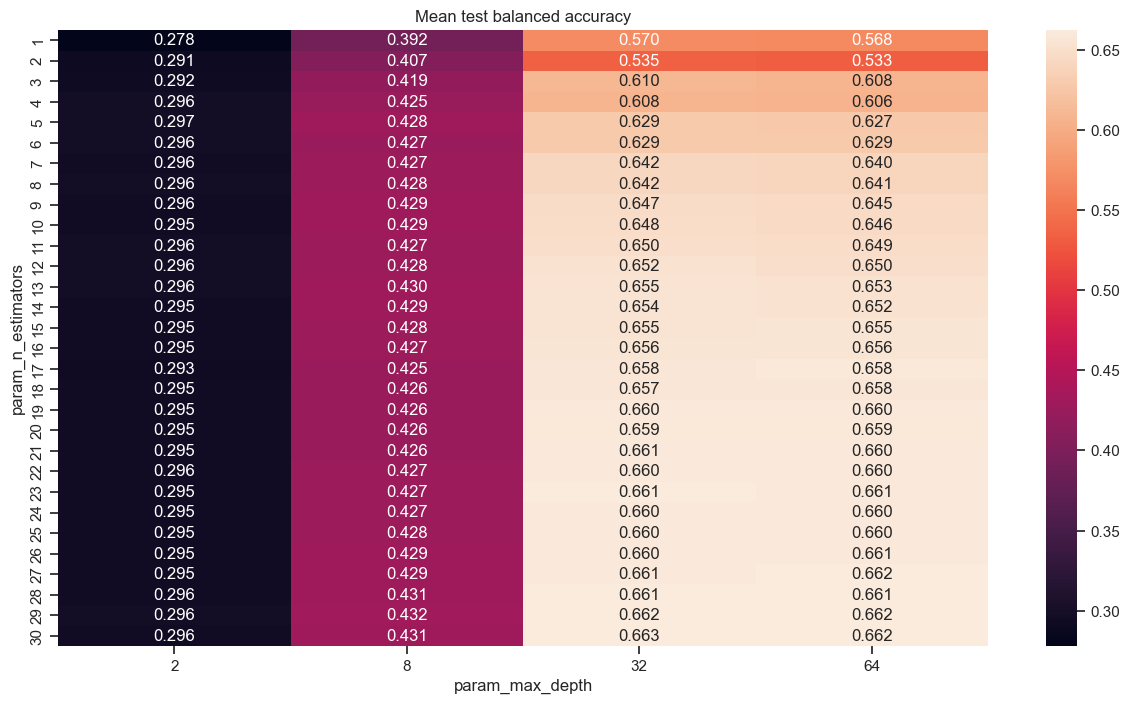

In [26]:
top_features = pd.DataFrame({'feature': features, 'importance': feature_importances}).sort_values('importance', ascending=False).head(10)['feature'].values

grid_params = {
        'n_estimators': np.arange(1, 31, 1),
        'max_depth': [2, 8, 32, 64]
    }

results_df2, rf_ba_top_features = evaluate_RF(pd.DataFrame(X, columns=features)[top_features].values, y,grid_params,  skf, accuracy=False)

In [27]:
rf_ba_top_features

RandomForestClassifier(max_depth=32, n_estimators=30, n_jobs=-1, random_state=1,
                       verbose=1)

In [31]:
results_df.loc[((results_df.param_max_depth==32) &(results_df.param_n_estimators==29)), ["mean_test_balanced_accuracy", "mean_fit_time"]]

mean_test_balanced_accuracy  mean_fit_time
28                     0.672082       7.489113

In [28]:
results_df2.loc[((results_df2.param_max_depth==32) &(results_df2.param_n_estimators==30)), ["mean_test_balanced_accuracy", "mean_fit_time"]]

mean_test_balanced_accuracy  mean_fit_time
89                     0.662559      36.059178

**Interpret the results**

- Based on `balanced_accuracy` and using only the top 10 features, the best model is the one with a `max_depth` of 32 and `n_estimators` of 30. The balanced accuracy slightly decreases compared to using all the features, and fitting time, weirdly increases by a factor of five.

## Exercise 5: Confusion matrix
Do a standard stratified holdout and generate the confusion matrix of the tuned random forest. Which classes are still often confused?

In [32]:
X_df, X_test, y_df, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf = RandomForestClassifier(n_estimators=30, max_depth=64, random_state=seed, n_jobs=-1, verbose=1)

clf.fit(X_df, y_df)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=classes))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.1s finished


                   precision    recall  f1-score   support

            Aspen       0.89      0.90      0.89      7775
Cottonwood_Willow       0.88      0.94      0.91     10324
      Douglas_fir       0.84      0.84      0.84      1439
        Krummholz       0.60      0.29      0.39       296
   Lodgepole_Pine       0.75      0.45      0.56       530
   Ponderosa_Pine       0.82      0.67      0.74       825
       Spruce_Fir       0.86      0.68      0.76       890

         accuracy                           0.87     22079
        macro avg       0.81      0.68      0.73     22079
     weighted avg       0.87      0.87      0.87     22079



<Axes: >

**Which classes are still often confused?**

- It is the one with less data

     + `Krummholz`
     + `Lodgepole_Pine`

## Exercise 6: A second-level model
Build a binary model specifically to correctly choose between the first and the second class.
Select only the data points with those classes and df a new random forest. Do a standard stratified split and plot the resulting ROC curve. Can we still improve the model by calibrating the threshold?

In [34]:
# dataframe of X and y
df = pd.DataFrame(X, columns=features)
df['classe'] = [classes[i] for i in y]

df.classe.value_counts()

classe
Cottonwood_Willow    51682
Aspen                38906
Douglas_fir           7375
Spruce_Fir            4508
Ponderosa_Pine        3969
Lodgepole_Pine        2614
Krummholz             1339
Name: count, dtype: int64

In [35]:
# df with only Cottonwood_Willow and Aspen in classe
df = df[(df.classe == 'Cottonwood_Willow') | (df.classe == 'Aspen')]
df.classe.value_counts()

classe
Cottonwood_Willow    51682
Aspen                38906
Name: count, dtype: int64

In [36]:
df.classe.unique()

array(['Cottonwood_Willow', 'Aspen'], dtype=object)

In [37]:
# split data
X, y = df.drop('classe', axis=1).values, df.classe.values

X_df, X_test, y_df, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

clf = RandomForestClassifier(n_estimators=30, max_depth=64, random_state=seed, n_jobs=-1, verbose=1)

clf.fit(X_df, y_df)   

y_pred = clf.predict(X_test)

# roc curve
y_pred_proba = clf.predict_proba(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished


In [38]:
def plot_roc_curve(y_test, y_pred_proba, ax=None):
   
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label='Cottonwood_Willow', drop_intermediate=False)
    roc_auc = auc(fpr, tpr)

    lw = 2
    ax.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{roc_auc:.2f} AUC') 

In [39]:
# roc curve for different thresholds
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

plot_roc_curve(y_test, y_pred_proba, axes)
    
plt.suptitle('ROC curve of Aspen(0) vs Cottonwood_Willow(1)', fontsize=10)
plt.tight_layout()
plt.legend(loc="lower right")
plt.show()

**Can we still improve the model by calibrating the threshold?**

Yes, we can. By either using a `sigmoid` or an `isotonic` calibrer

## Exercise 7: Model calibration
For the trained binary random forest model, plot a calibration curve (see [course notebook](https://ml-course.github.io/engineer/slides_html/03%20-%20Model%20Selection.slides.html#/40)).
Next, try to correct for this using Platt Scaling (or sigmoid scaling).

Probability calibration should be done on new data not used for model fitting. The class [CalibratedClassifierCV](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) uses a cross-validation generator and estimates for each split the model parameter on the df samples and the calibration of the test samples. The probabilities predicted for the folds are then averaged. Already fitted classifiers can be calibrated by CalibratedClassifierCV via the parameter cv=”prefit”. [Read more](https://scikit-learn.org/stable/modules/calibration.html)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs

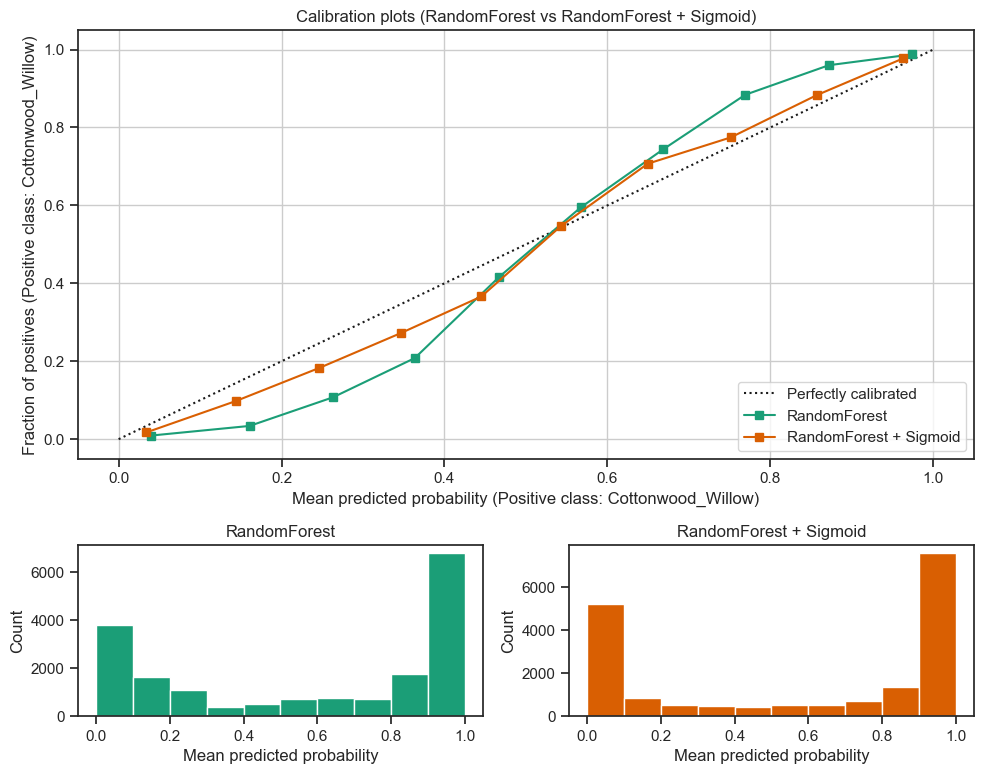

In [40]:
rf_sigmoid = CalibratedClassifierCV(clf, cv=2, method="sigmoid")

clf_list = [
    (clf, "RandomForest"),
    (rf_sigmoid, "RandomForest + Sigmoid")
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    if name != "RandomForest":
        clf.fit(X_df, y_df)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (RandomForest vs RandomForest + Sigmoid)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Exercise 8: Gradient Boosting
Implement a function `evaluate_GB` that measures the performance of `GradientBoostingClassifier` or the `XGBoostClassifier` for
different learning rates (0.01, 0.1, 1, and 10). As before, use a 3-fold cross-validation. You can use a 5% stratified sample of the whole dataset.
Finally plot the results for `n_estimators` ranging from 1 to 100. Run all the GBClassifiers with `random_state=1` to ensure reproducibility.

Implement a function that plots the score of `evaluate_GB` for `n_estimators` = 10,20,30,...,100 on a linear scale.

In [43]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

def evaluate_GB(X, y, skf, accuracy=True):
    grid_params = {
        'eta': [0.01, 0.1, 1, 10],
        'n_estimators': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    }
    grid_search = GridSearchCV(XGBClassifier(random_state=seed, n_jobs=-1, verbose=1), grid_params, cv=skf, n_jobs=-1, verbose=3,
                               scoring=('accuracy', 'f1_macro', 'balanced_accuracy'), refit='balanced_accuracy', return_train_score=True)
    grid_search.fit(X, y)
    results = pd.DataFrame(grid_search.cv_results_)
    plt.figure(figsize=(15, 8))
    if accuracy:
        sns.heatmap(results.pivot_table(index='param_n_estimators', columns='param_eta', values='mean_test_accuracy'), annot=True, fmt=".3f")
        plt.title('Mean test accuracy')
    else:
        sns.heatmap(results.pivot_table(index='param_n_estimators', columns='param_eta', values='mean_test_balanced_accuracy'), annot=True, fmt=".3f")
        plt.title('Mean test balanced accuracy')
    plt.show()
    return results, grid_search.best_estimator_

Fitting 3 folds for each of 44 candidates, totalling 132 fits


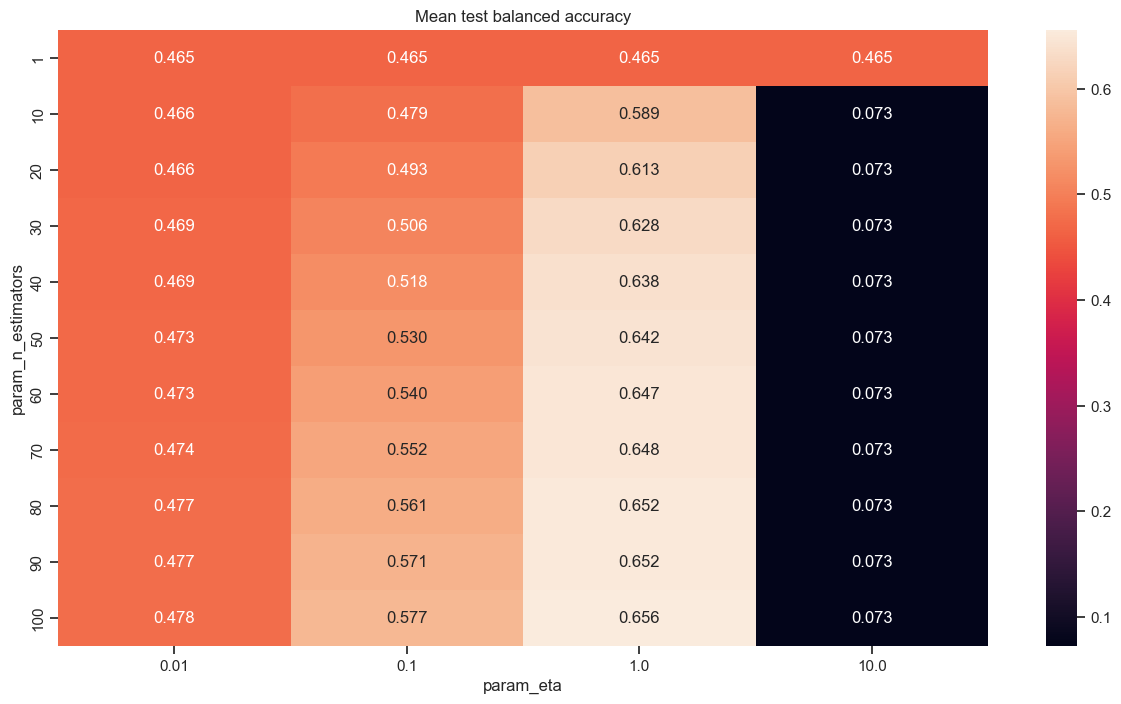

In [45]:
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array');

results_df_gb, best_gb = evaluate_GB(X, y, skf, False)